In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint


In [6]:
# Load data
df = pd.read_csv("Maruti Suzuki.csv")

# Optional: Strip whitespaces in column names
df.columns = df.columns.str.strip()

print(df.columns)


Index(['Date', 'OPEN', 'HIGH', 'LOW', 'PREV. CLOSE', 'close', 'VOLUME'], dtype='object')


In [8]:
# Select important features
features = ['OPEN', 'HIGH', 'LOW', 'PREV. CLOSE', 'close', 'VOLUME']
df = df[features]

# Check for nulls
df.dropna(inplace=True)

C:\Users\SREE\AppData\Local\Temp\ipykernel_3472\1450663453.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [10]:
# Drop 'Date' column if it exists
if 'Date' in df.columns:
    df = df.drop(columns=['Date'])


In [11]:
for col in ['OPEN', 'HIGH', 'LOW', 'PREV. CLOSE', 'close', 'VOLUME']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '', regex=False).astype(float)


In [12]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled_data, columns=features)


In [14]:
def create_sequences(data, target_col_index, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])  # past window_size days
        y.append(data[i, target_col_index])  # today's close price
    return np.array(X), np.array(y)

window_size = 60  # past 60 days
target_col_index = features.index('close')

X, y = create_sequences(scaled_data, target_col_index, window_size)


In [15]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [16]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Save best model
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint], shuffle=False)


C:\Users\SREE\anaconda3\envs\tf-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,301 (481.64 KB)

 Trainable params: 123,301 (481.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.2070
Epoch 1: val_loss improved from inf to 0.00289, saving model to best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - loss: 0.2017 - val_loss: 0.0029
Epoch 2/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0387
Epoch 2: val_loss improved from 0.00289 to 0.00217, saving model to best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0375 - val_loss: 0.0022
Epoch 3/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0468
Epoch 3: val_loss improved from 0.00217 to 0.00195, saving model to best_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0451 - val_loss: 0.0020
Epoch 4/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0155
Epoch 4: val_loss did not improve from 0.00195
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0150 - val_loss: 0.0031
Epoch 5/50
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0092
Epoch 5: val_loss did not improve from 0.00195
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s

In [17]:
# Predict
preds = model.predict(X_test)

# Inverse transform
dummy_pred = np.zeros((len(preds), len(features)))
dummy_pred[:, target_col_index] = preds[:, 0]
predicted_prices = scaler.inverse_transform(dummy_pred)[:, target_col_index]

dummy_actual = np.zeros((len(y_test), len(features)))
dummy_actual[:, target_col_index] = y_test
actual_prices = scaler.inverse_transform(dummy_actual)[:, target_col_index]


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step 


In [18]:
mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))

print(f"MAE: ₹{mae:.2f}")
print(f"RMSE: ₹{rmse:.2f}")


MAE: ₹142.07
RMSE: ₹182.43


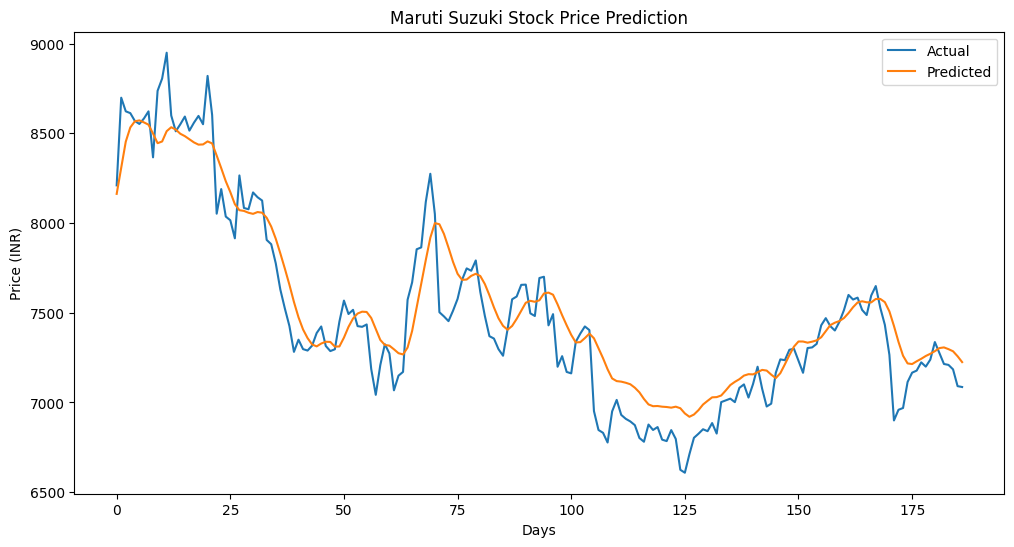

In [19]:
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label='Actual')
plt.plot(predicted_prices, label='Predicted')
plt.title("Maruti Suzuki Stock Price Prediction")
plt.xlabel("Days")
plt.ylabel("Price (INR)")
plt.legend()
plt.show()
